<i>Written by: Laura Brin, Sandra Alex & Annabell Rodriguez, On behalf of Norquest College Institute for the CMPT-3510 Machine Learning I Fall course</i>

# House Price Regression

We'll be using a labeled dataset that contain features representing house characteristics like measurements, number of rooms, location and price. The last one (price) is the class that we are looking to predict based on the rest of the features. The data was collected from King County, USA. This dataset is from Kaggle. More information about the dataset can be found here: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction. 

In [1]:
#Crucial data processing and analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import datetime as dt


# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# loading the house sales csv data
df = pd.read_csv("kc_house_data.csv")

# This makes it so we are able to see 100 rows when displaying the data
pd.set_option("display.max_rows", 100)

### Problem definition

The tendency of the house prices in United States is to grothw. That have been the trend over the last years. In our dataset is difficult to visualize this pattern because it only covers 2 years, from May 2014 to May 2015.

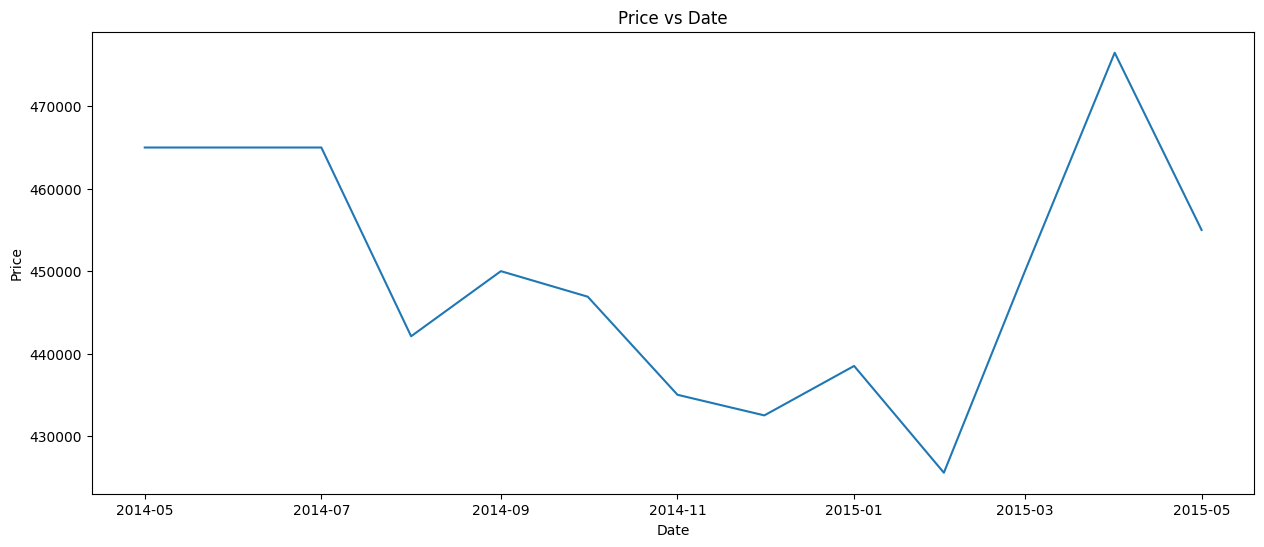

In [2]:
df["date"] = pd.to_datetime(df["date"])
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
plt.figure(figsize=(15,6))
out_price = df.groupby('month')['price'].median().reset_index(name ='Price')
sns.lineplot(x='month',y='Price',data=out_price)
plt.title("Price vs Date")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

But, we can see this trend analyzing the data provided by Fred (https://fred.stlouisfed.org/series/MSPUS)

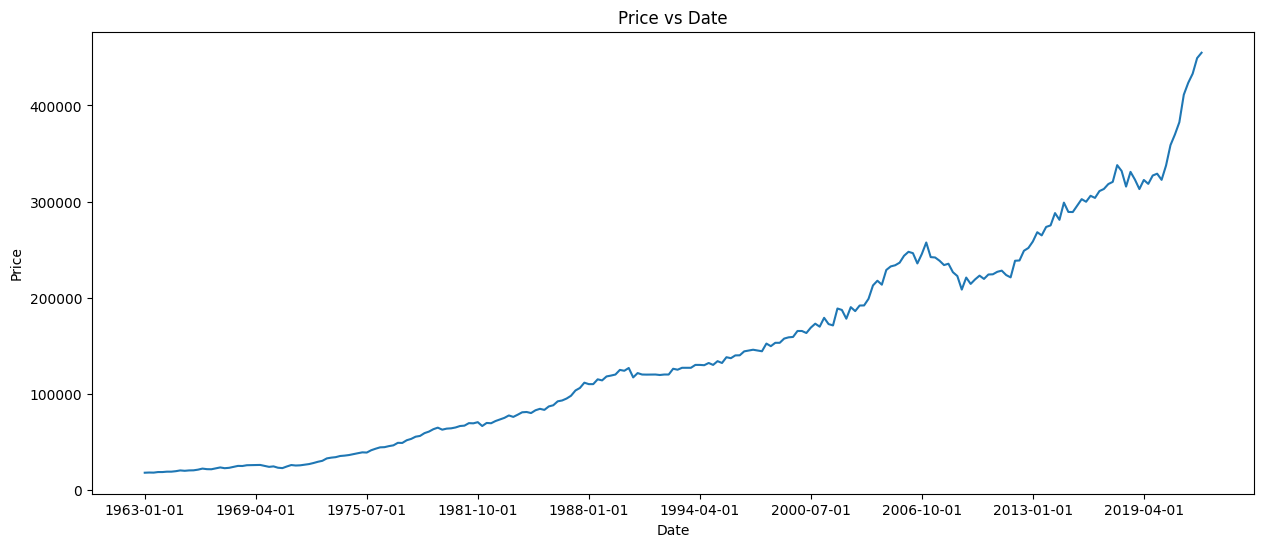

In [3]:
df_fred = pd.read_csv("MSPUS.csv")

plt.figure(figsize=(15,6))
sns.lineplot(x='observation_date',y='MSPUS',data=df_fred)
plt.title("Price vs Date")
plt.xlabel("Date")
plt.ylabel("Price")
every_nth_xtick = 25
plt.xticks(np.arange(0, len(df_fred)+10, every_nth_xtick))
plt.show()

    For people trying to buy or sell a house, this can be problematic. The first ones need to know if the price of the house is fair according to the changes in the market and some other factors that influence its price like physical characteristics (number of rooms, size, location, etc) or the market fluctuation due to inflation, economical crisis, among others. For the second case, when you are trying to sell, you want to get the most from your house, then it is important to take all the factors mentioned before into account. Then having a model that helps people to predict the price of a particular house can be a solution for many. 
    
    This dataset contains 19 features. These are:

date - Date of the home sale<br>
bedrooms - Number of bedrooms<br>
bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower<br>
sqft_living - Square footage of the apartments interior living space<br>
sqft_lot - Square footage of the land space<br>
floors - Number of floors<br>
waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not<br>
view - An index from 0 to 4 of how good the view of the property was<br>
condition - An index from 1 to 5 on the condition of the apartment<br>
grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design<br>
sqft_above - The square footage of the interior housing space that is above ground level<br>
sqft_basement - The square footage of the interior housing space that is below ground level<br>
yr_built - The year the house was initially built<br>
yr_renovated - The year of the house's last renovation<br>
zipcode - What zipcode area the house is in<br>
lat - Lattitude<br>
long - Longitude<br>
sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors<br>
sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors<br>

Every observation in the dataset represents a house sold in that specific date. The date granularity is daily, it contains the day, month and year in which the house was sold, which means that for a single day we can have multiple records. As we mentioned before, the years represented are 2014 and 2015.

### Data Cleaning

In [4]:
#code saver

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014-10-01
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014-12-01
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015-02-01
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014-12-01
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015-02-01


In [6]:
df.shape

(21613, 22)

In [7]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [8]:
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
month            datetime64[ns]
dtype: object

In [9]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
month            0
dtype: int64

**Cleaning Notes**: <br>
need to change date- strip T00 and convert to_datetime <br>
yr_renovated change 0 to NaN <br>
waterfront to binary <br>
grade to categories then encode <br>
sqft_living, sqft_lot, sqft_above, sqft_below, sqft_living15, sqft_lot15 could normalize <br>
condition and view are both categorical, but as they are currently numerical and ordinal there is no needed cleaning



date:

In [10]:
df_clean=df.copy()
df_clean["date"].astype("string").str.rstrip("T000000") 
df_clean["date"]=df_clean["date"].values.astype("datetime64[D]")
df_clean.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
month            datetime64[ns]
dtype: object

yr_renovated: NaN for missing years

In [11]:
df_clean["yr_renovated"].replace(0,np.NaN, inplace=True)

waterfront:

In [12]:
df_clean["waterfront"].unique()

array([0, 1], dtype=int64)

In [13]:
df_clean["waterfront"]=df_clean["waterfront"].astype(bool)

grade: categorize and encode

In [14]:
df_clean["grade"].unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13,  1], dtype=int64)

In [15]:
df_clean["grade"]=pd.cut(df_clean["grade"],bins=[1,4,11,13],labels=["low","average","high"])

In [16]:
df_clean=pd.get_dummies(df_clean, columns=["grade"],prefix="grade", drop_first=True)

In [17]:
df_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,grade_average,grade_high
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,False,0,...,1955,NaN,98178,47.5112,-122.257,1340,5650,2014-10-01,1,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,False,0,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014-12-01,1,0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,False,0,...,1933,NaN,98028,47.7379,-122.233,2720,8062,2015-02-01,1,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,False,0,...,1965,NaN,98136,47.5208,-122.393,1360,5000,2014-12-01,1,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,False,0,...,1987,NaN,98074,47.6168,-122.045,1800,7503,2015-02-01,1,0


In [18]:
df_clean.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                 bool
view                      int64
condition                 int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated            float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
month            datetime64[ns]
grade_average             uint8
grade_high                uint8
dtype: object

### Data Visualization

In [19]:
df_clean.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'grade_average', 'grade_high'],
      dtype='object')

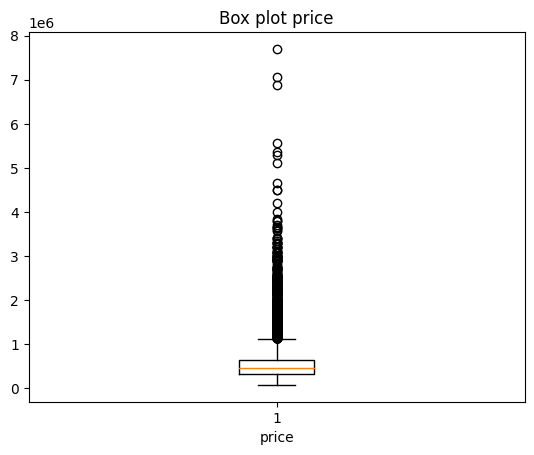

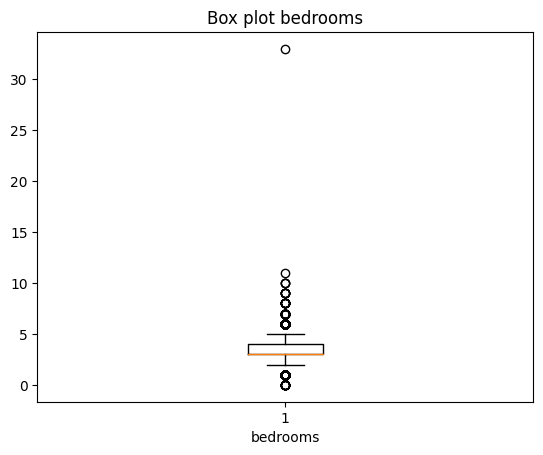

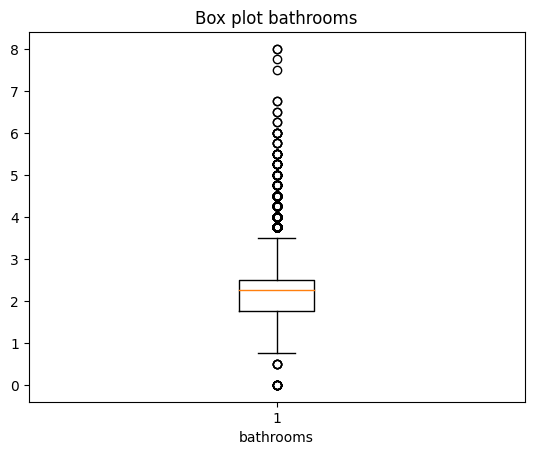

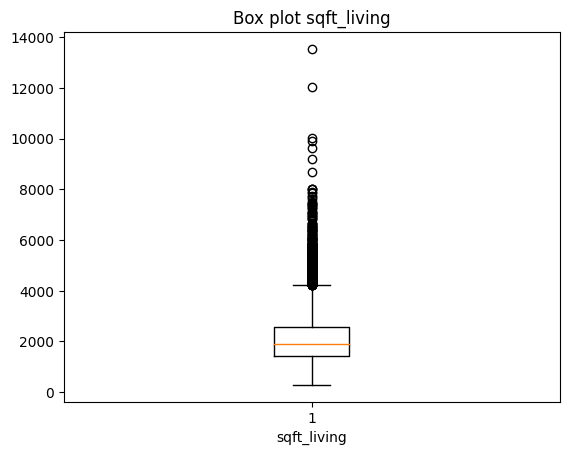

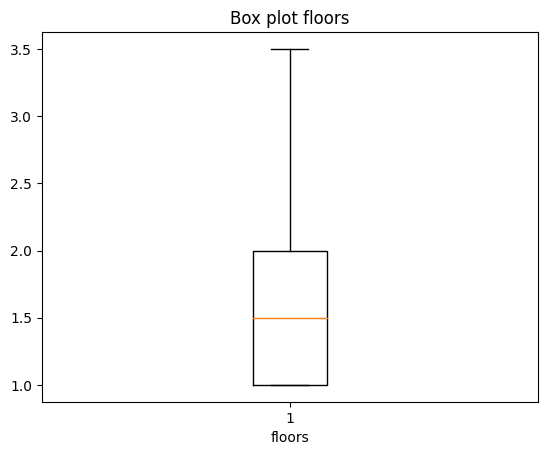

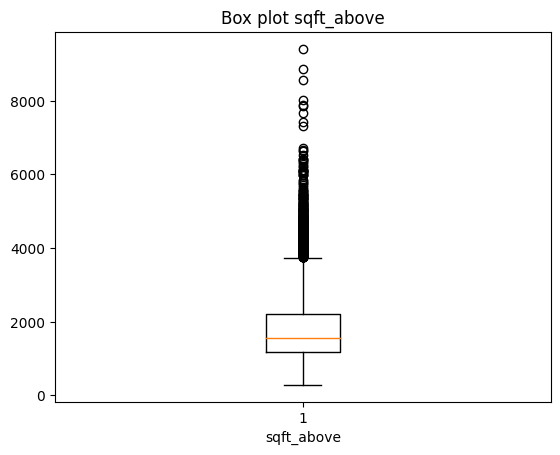

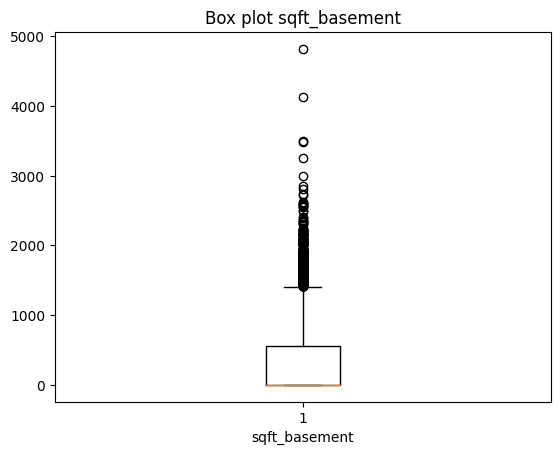

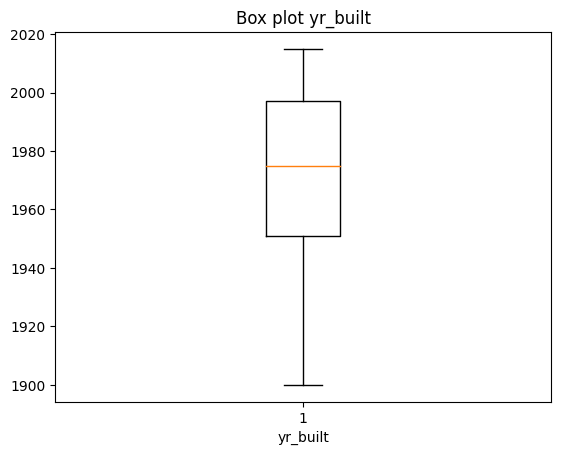

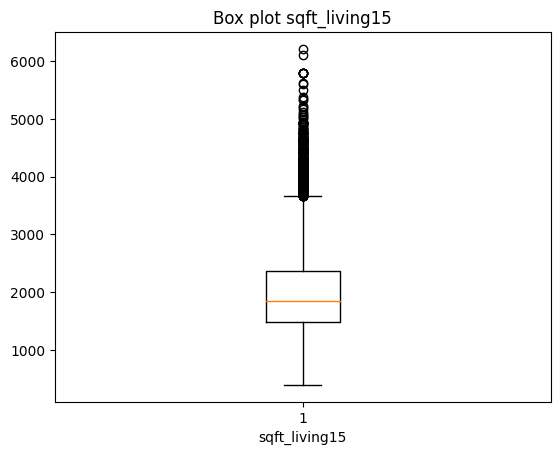

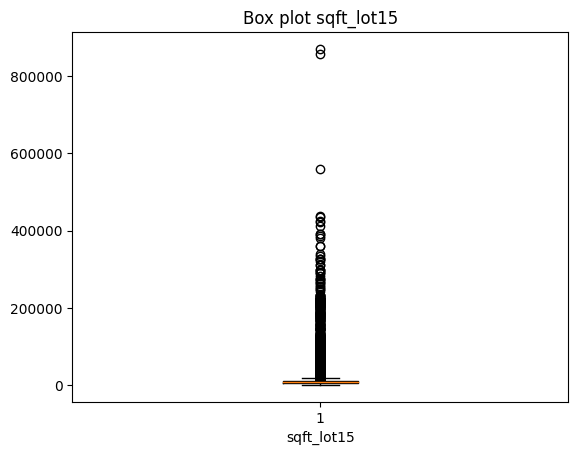

In [20]:
list_box = ["price", "bedrooms", "bathrooms", "sqft_living", "floors", "sqft_above", "sqft_basement", "yr_built", "sqft_living15", "sqft_lot15"]
for column_box in list_box:
    plt.boxplot(df_clean[column_box])
    plt.xlabel(column_box)
    plt.title(f"Box plot {column_box}")
    plt.show()

**insights from boxplots** <br>
All features except yr_built and floors showed significant collective outliers. <br> 
Bedrooms had a single global outlier >30. sqft_living has a potential global outlier at 12000 sqft.  <br>
Not checked: lat, long and zipcode as they are geographic location features. <br>
Not checked: waterfront as it is binary; condition and grade are catagorical; view is a 1-5 scale; yr_renovated NaN values <br>


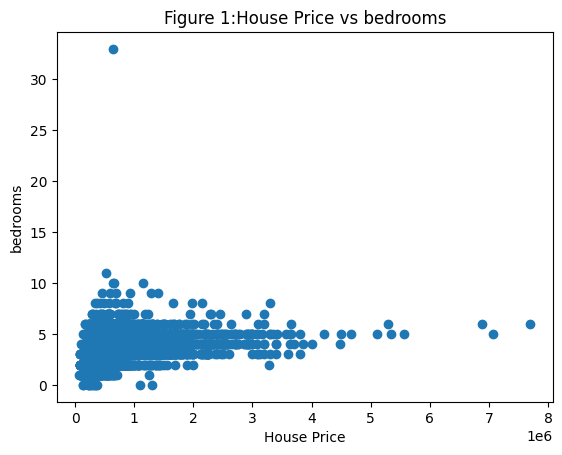

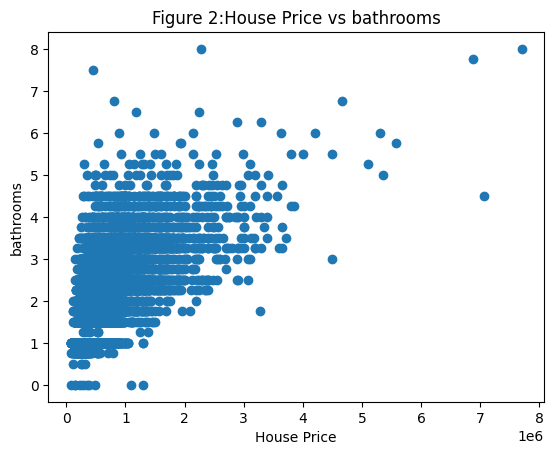

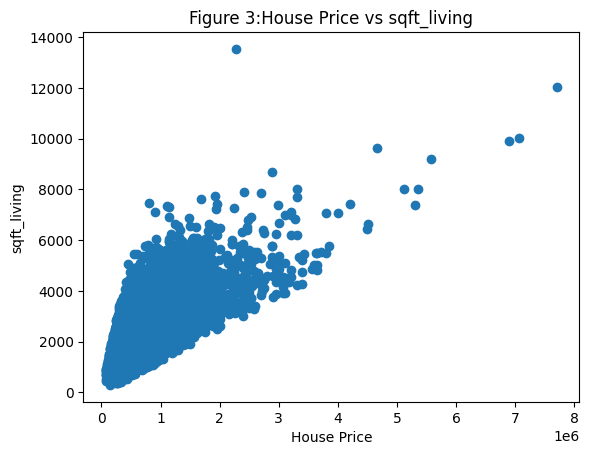

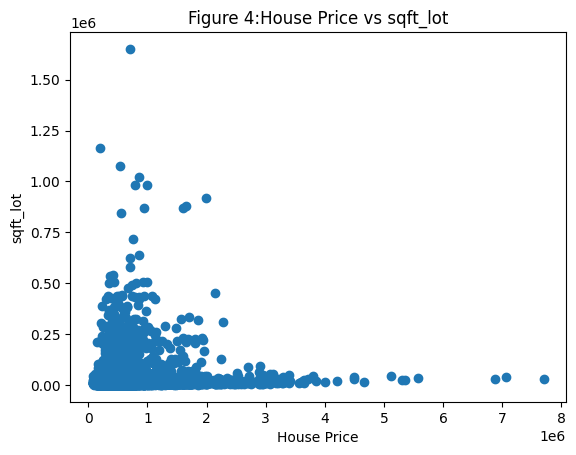

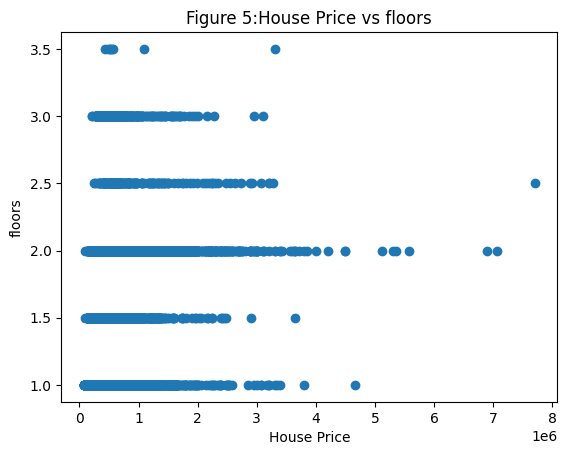

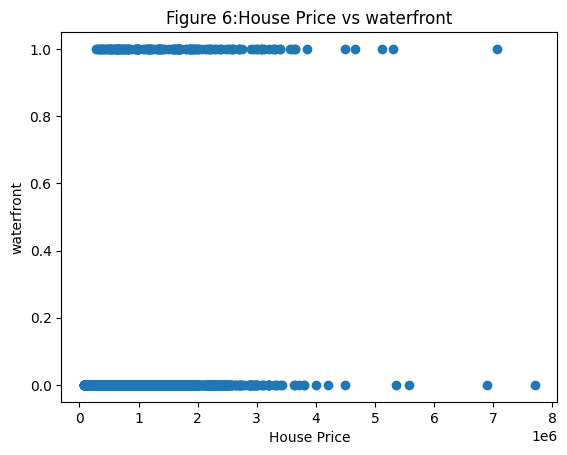

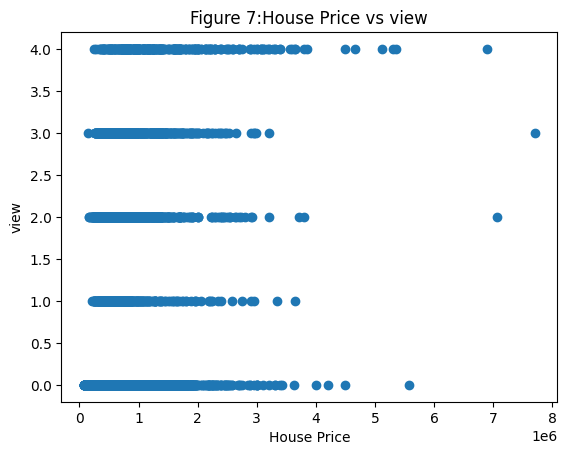

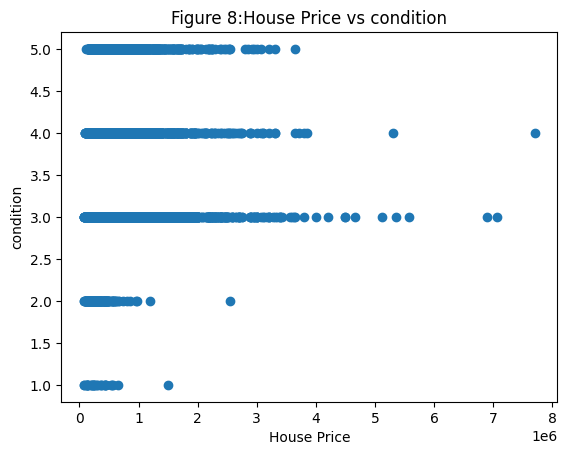

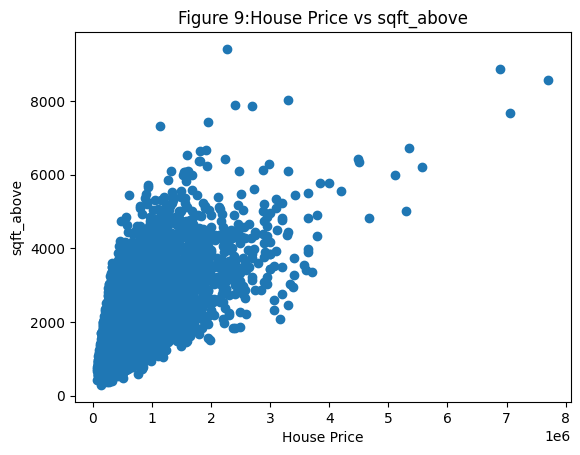

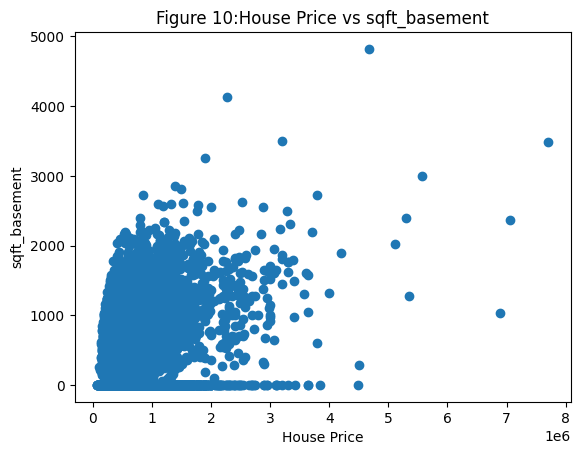

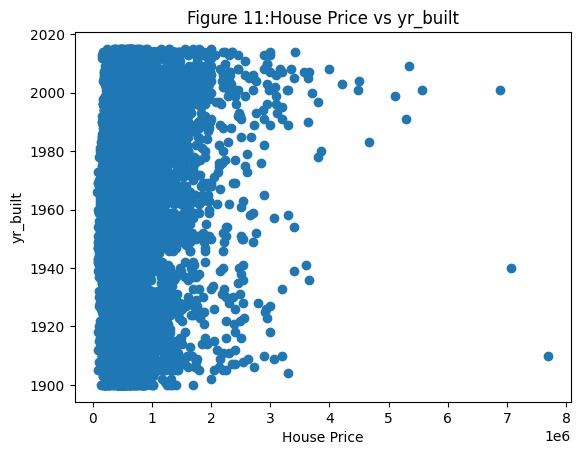

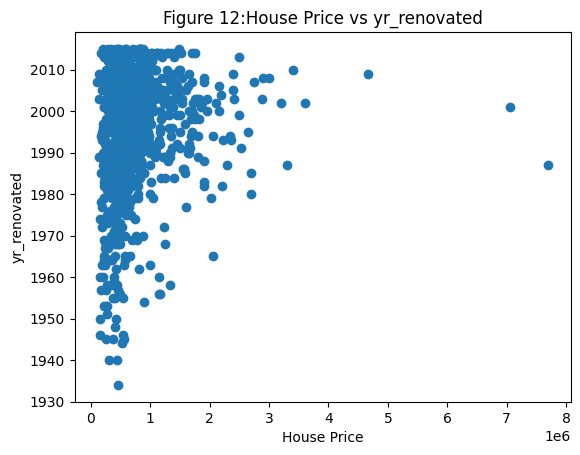

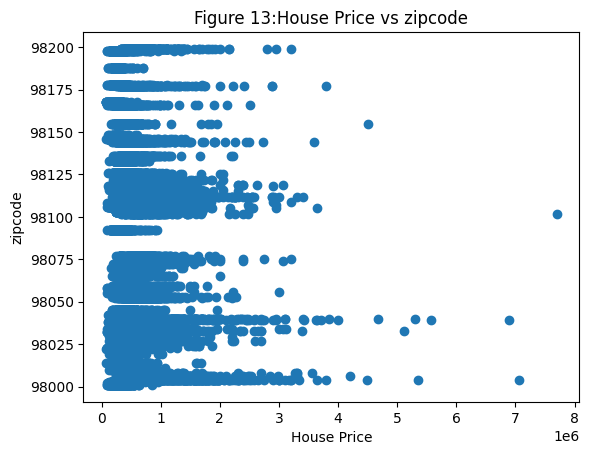

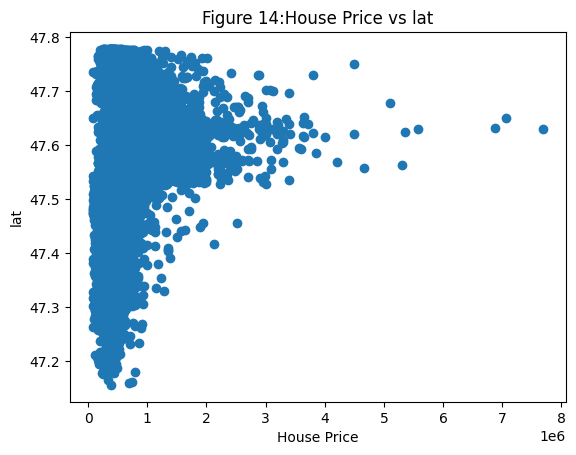

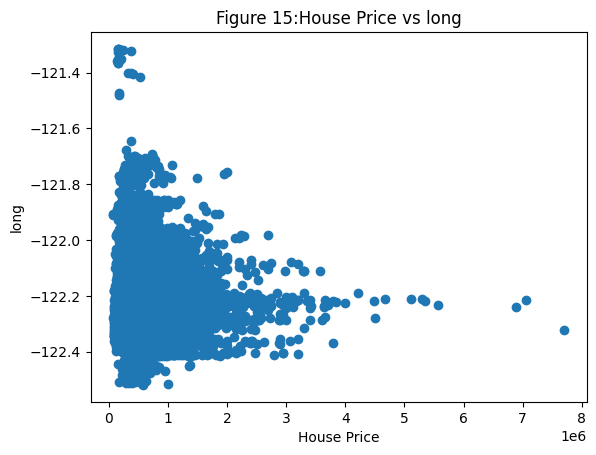

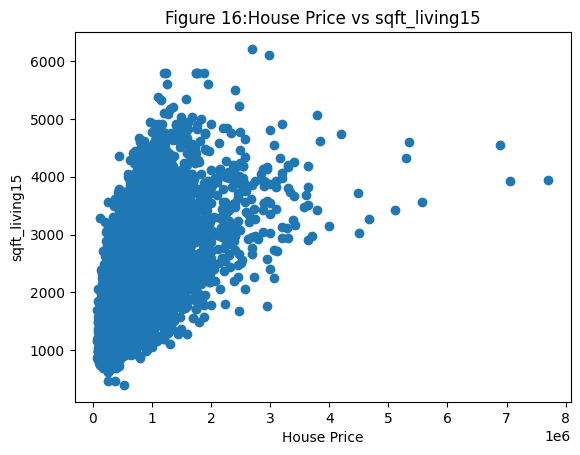

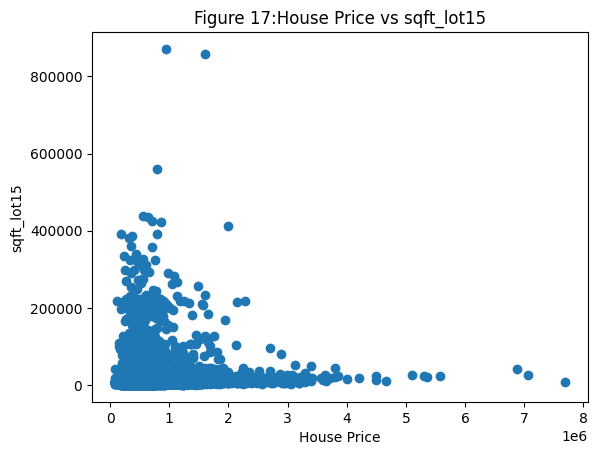

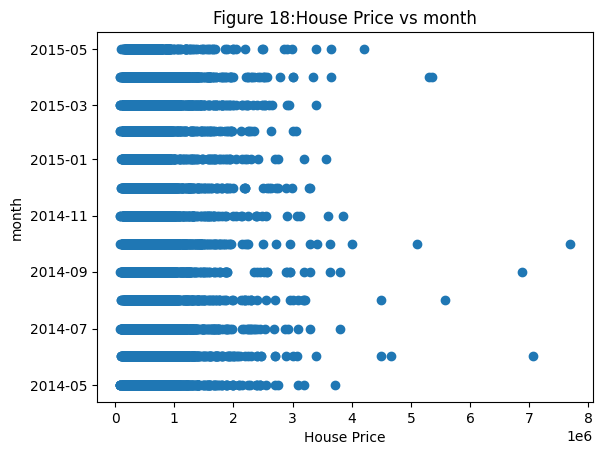

In [21]:
features=df_clean.columns
features=features.drop(["id","date","price","grade_average","grade_high"])
graph=1
for col in features:
    fig=plt.scatter(df_clean["price"],df_clean[col])
    plt.xlabel("House Price")
    plt.ylabel(f"{col}")
    plt.title(f"Figure {graph}:House Price vs {col}")
    plt.show()
    graph+=1

**Insights from scatterplots**: <br>
living space square footage appears to have a lower bound where house price will not exceed $200/sqft <br>
upper floor sqft has obvious correlation with total living space sqft <br>
appears to be a positive correlation with condition of house and price (at least at higher prices) <br>
view rating and waterfront did not have obvious strong coorelation with house price. <br>
There appears to be a specific lat-long that correlated to the most expensive properties (Bellevue neighbourbhood in Seattle).

sqft living and sqft lot each have 1 global outlier to remove. sqft_lot15 has 2 global outliers to remove


[Text(0.5, 1.0, 'Figure 18:Heatmap of Correlation for Housing features')]

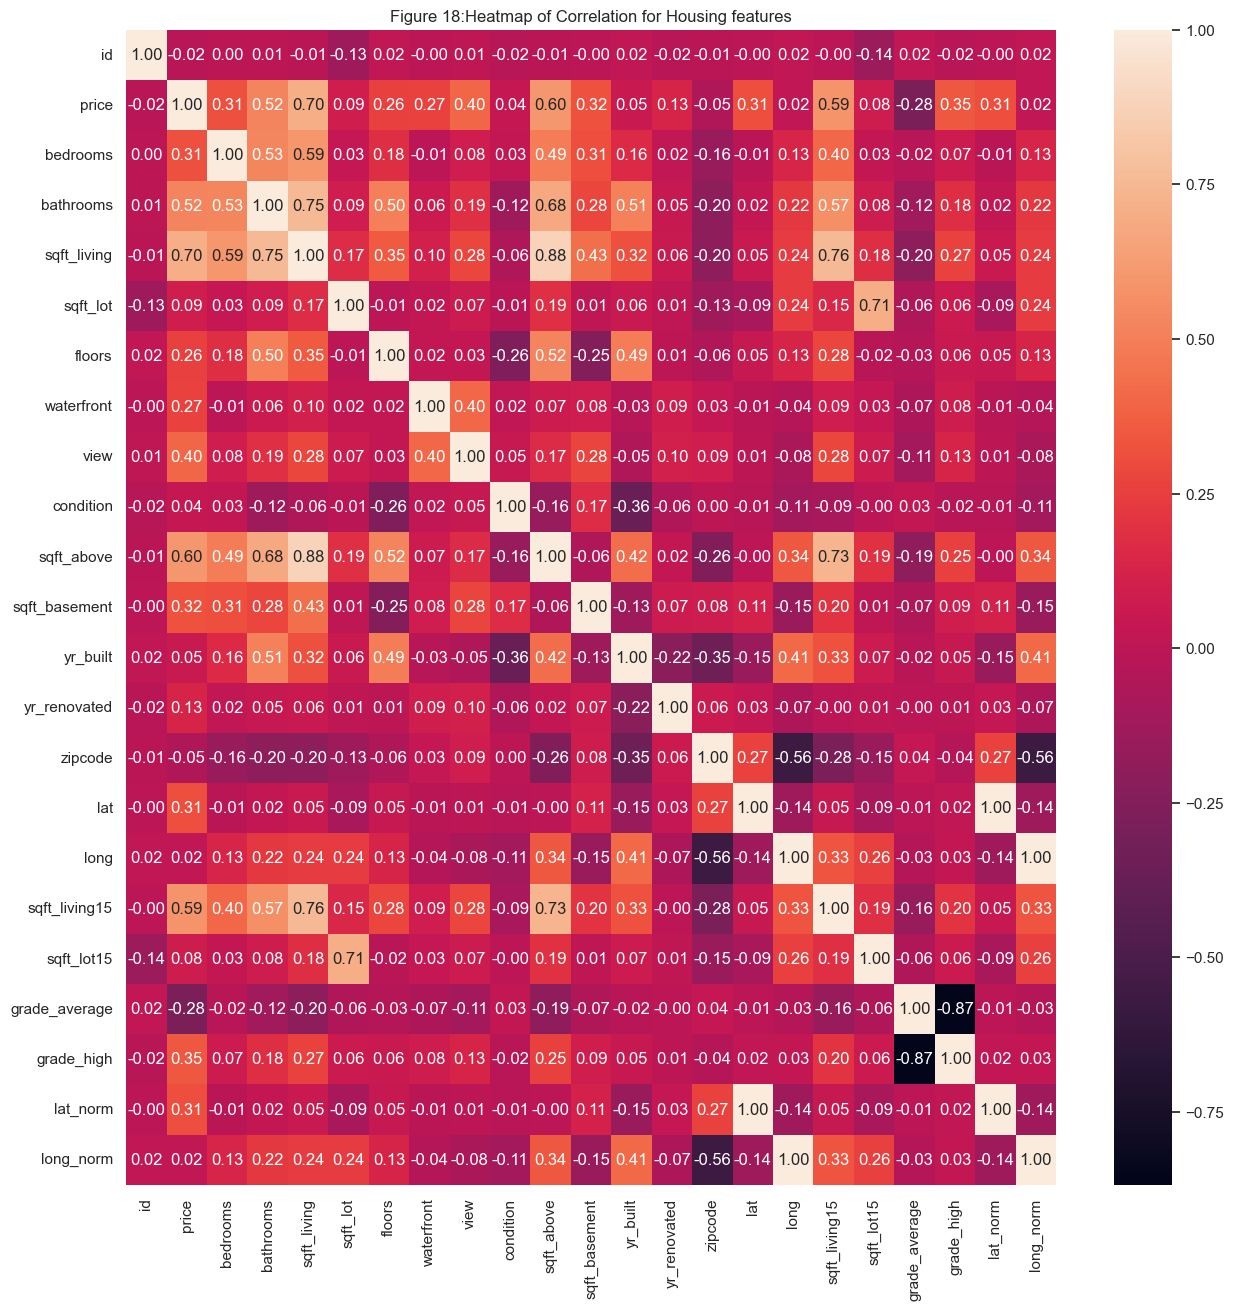

In [65]:
corr=df_clean.corr()

correlation_heatmap=plt.figure(num=None, figsize=(15,15))
correlation_heatmap=sns.heatmap(data=corr,annot=True, fmt='.2f').set(title="Figure 18:Heatmap of Correlation for Housing features")
sns.set(font_scale=0.8)

correlation_heatmap

**Insights from correlation plot** <br>
Price is moderately correlated with sqft_living, sqft_above and sqft_living15. Bedrooms and bathrooms have low correlation with price but moderate correlation with sqft_living. View has a higher correlation than waterfront. While the latitude and longitude had clear patterns in the scatterplots, only the latitue shows a minor correlation. 

From data visualizations the following cleaning is required: <br>
* remove bedroom, sqft_living, sqft_lot, and sqft_lot15 outliers
* normalize lat and long values

In [23]:
df_clean.drop(df_clean[df_clean["bedrooms"]>30].index, inplace=True)
df_clean.drop(df_clean[df_clean["sqft_living"]>13000].index, inplace=True)
df_clean.drop(df_clean[df_clean["sqft_lot"]>1500000].index, inplace=True)
df_clean.drop(df_clean[df_clean["sqft_lot15"]>800000].index, inplace=True)

In [24]:
df_clean.isnull().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated     20694
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
month                0
grade_average        0
grade_high           0
dtype: int64

In [25]:
df_clean["yr_renovated"].replace(np.NaN, 0, inplace=True)

In [26]:
scaler=MinMaxScaler()
lat_array=df_clean["lat"].values.reshape(-1,1)
long_array=df_clean["long"].values.reshape(-1,1)

df_clean["lat_norm"]=normalize(lat_array, axis=0)
df_clean["long_norm"]=normalize(long_array, axis=0)

[Text(0.5, 1.0, 'Figure 19: Heatmap of Correlation for Housing features')]

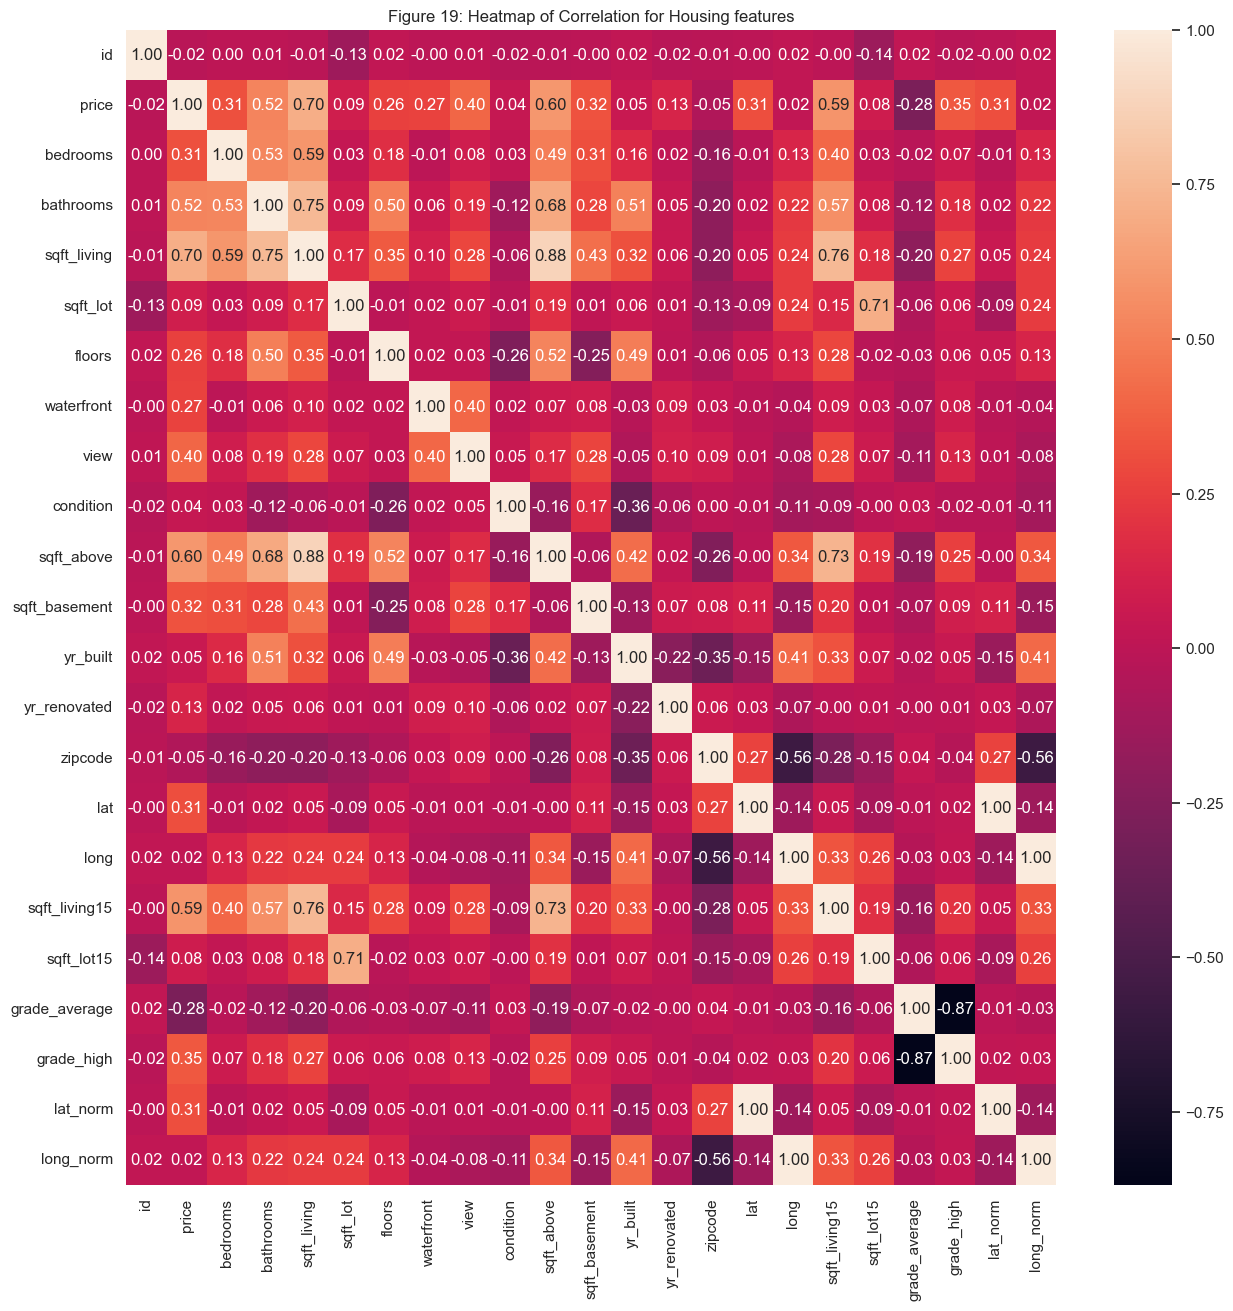

In [61]:
corr2=df_clean.corr()

correlation_heatmap2=plt.figure(num=None, figsize=(15,15))
correlation_heatmap2=sns.heatmap(data=corr2,annot=True, fmt='.2f').set(title="Figure 19: Heatmap of Correlation for Housing features")
sns.set(font_scale=1.5)

correlation_heatmap2

In [28]:
df_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,month,grade_average,grade_high,lat_norm,long_norm
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,False,0,...,98178,47.5112,-122.257,1340,5650,2014-10-01,1,0,0.006796,-0.006805
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,False,0,...,98125,47.7210,-122.319,1690,7639,2014-12-01,1,0,0.006826,-0.006809
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,False,0,...,98028,47.7379,-122.233,2720,8062,2015-02-01,1,0,0.006828,-0.006804
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,False,0,...,98136,47.5208,-122.393,1360,5000,2014-12-01,1,0,0.006797,-0.006813
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,False,0,...,98074,47.6168,-122.045,1800,7503,2015-02-01,1,0,0.006811,-0.006793


normalizing latitude did not have any markable result, normalizing longitude did have an effect of increasing correlation with price but only to low levels <b>


### Regression

KNN Regression: target price will be predicted by using interpolation of the price of the nearest neighbours
Decision Tree Regression: target price will be predicted based on a tree 

#### Initializing Classification Models

In [75]:
tree=DecisionTreeRegressor()
forest=RandomForestClassifier()
knn=KNeighborsRegressor()
bayes=BayesianRidge()


In [76]:
tree_random=DecisionTreeRegressor()
forest_random=RandomForestClassifier()
knn_random=KNeighborsRegressor()
bayes_random=BayesianRidge()

#### Spliting Data

In [84]:
df_regress=df_clean.copy()
df_regress.drop(["id","lat_norm","long_norm","month"], inplace=True, axis=1)#,"yr_renovated"
df_regress["date"]=df_regress["date"].map(dt.datetime.toordinal)

X_clean = df_regress.loc[:, df_regress.columns != 'price']
y_clean = df_regress.loc[:, df_regress.columns == 'price']

In [32]:
X_split, X_valid, y_split, y_valid = train_test_split(X_clean,y_clean, train_size=0.8, random_state=42)
X_train, X_test, y_train, y_test = train_test_split( X_split, y_split, train_size=0.75, random_state=42)

#### KNN Regression

In [33]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [34]:
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.5093944668944438

KNN regression using default settings results in an accuracy score of 0.509

Appliying RandomizedSearchCV

In [78]:
#parameters to test
n_neighbors= [3,5,7,9,11,13,15,55,99]
weights=["uniform","distance"]
#algorithm = ['ball_tree', 'kd_tree', 'brute']
p = [1, 2, 3]
leaf_size = [20, 30, 40]

cross_validation = 3

num_of_iterations = 50

k_random_grid={"n_neighbors":n_neighbors, "weights": weights, "p":p, "leaf_size":leaf_size}

In [79]:
knn_random = RandomizedSearchCV(estimator = knn_random, param_distributions = k_random_grid, n_iter = num_of_iterations, cv = cross_validation, verbose=3, random_state=25, n_jobs = -1)

In [80]:
knn_random.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'leaf_size': [20, 30, 40],
                                        'n_neighbors': [3, 5, 7, 9, 11, 13, 15,
                                                        55, 99],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=25, verbose=3)

In [81]:
knn_random.score(X_test, y_test)

0.5549123231474862

In [82]:
knn_random.best_params_

{'weights': 'distance', 'p': 1, 'n_neighbors': 9, 'leaf_size': 40}

In [68]:
knn_random.score(X_valid, y_valid)

0.5417790398414937

KNN with features selected by randomized search with parameters {'weights': 'distance', 'p': 1, 'n_neighbors': 11, 'leaf_size': 20, 'algorithm': 'brute'} 
results in an accuracy score of 0.559 for the test set and 0.542 for the validation set, marginally better than the default.

Removing the algorithm options, the randomized search with parameters {'weights': 'distance', 'p': 1, 'n_neighbors': 9, 'leaf_size': 40}
results in an accuracy score of 0.555 for the test set, an 0.542 for the validation set.


#### Decision Tree Regression

In [41]:
tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [42]:
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.717532721826234

Appliying RandomizedSearchCV

In [43]:
#parameters
min_samples_split = [2, 3, 4]
max_features= ["sqrt","log2",None]
ccp_alpha=[0.0,0.01,0.02,0.03]
min_weight_fraction_leaf=[0.0,0.01,0.02,0.03]

cross_validation = 3

num_of_iterations = 50

random_grid = {'min_samples_split': min_samples_split,
                    "max_features": max_features, "ccp_alpha":ccp_alpha,
                    "min_weight_fraction_leaf":min_weight_fraction_leaf}


In [44]:
tree_random = RandomizedSearchCV(estimator = tree_random, param_distributions = random_grid, n_iter = num_of_iterations, cv = cross_validation, verbose=1, random_state=25, n_jobs = -1)

In [45]:
tree_random.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.0, 0.01, 0.02, 0.03],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_split': [2, 3, 4],
                                        'min_weight_fraction_leaf': [0.0, 0.01,
                                                                     0.02,
                                                                     0.03]},
                   random_state=25, verbose=1)

In [46]:
tree_random.score(X_test, y_test)

0.7397049393649162

In [47]:
tree_random.best_params_

{'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 4,
 'max_features': None,
 'ccp_alpha': 0.03}

In [48]:
tree_random.score(X_valid, y_valid)

0.7610020069644872

The Regression Tree accuracy score with default parameters is 0.718

The Regression Tree accuracy score with parameters {'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'max_features': None, 'ccp_alpha': 0.03}
is 0.740 for the test set and 0.761 for the validation set

#### BayesianRidge

In [49]:
bayes.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'n_iter': 300,
 'normalize': 'deprecated',
 'tol': 0.001,
 'verbose': False}

In [50]:
bayes.fit(X_train, y_train.values.ravel())
bayes.score(X_test, y_test.values.ravel())

0.6969895997810232

Appliying RandomizedSearchCV

In [51]:
#parameters to test
n_iter= [200, 300, 400]

alpha_1 = [1e-05, 1e-06, 1e-07]
alpha_2 = [1e-05, 1e-06, 1e-07]
lambda_1 = [1e-05, 1e-06, 1e-07]
lambda_2 = [1e-05, 1e-06, 1e-07]
tol = [0.01, 0.001, 0.0001]

cross_validation = 3

num_of_iterations = 50

random_grid={"n_iter":n_iter, "alpha_1":alpha_1, "alpha_2":alpha_2,
 "lambda_1":lambda_1, "lambda_2":lambda_2, "tol":tol }

In [52]:
bayes_random = RandomizedSearchCV(estimator = bayes_random, param_distributions = random_grid, n_iter = num_of_iterations, cv = cross_validation, verbose=1, random_state=25, n_jobs = -1)

In [53]:
bayes_random.fit(X_train,y_train.values.ravel())

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=BayesianRidge(), n_iter=50, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-05, 1e-06, 1e-07],
                                        'alpha_2': [1e-05, 1e-06, 1e-07],
                                        'lambda_1': [1e-05, 1e-06, 1e-07],
                                        'lambda_2': [1e-05, 1e-06, 1e-07],
                                        'n_iter': [200, 300, 400],
                                        'tol': [0.01, 0.001, 0.0001]},
                   random_state=25, verbose=1)

In [54]:
bayes_random.score(X_test, y_test)

0.6969895997072233

In [55]:
bayes_random.best_params_

{'tol': 0.01,
 'n_iter': 400,
 'lambda_2': 1e-05,
 'lambda_1': 1e-05,
 'alpha_2': 1e-06,
 'alpha_1': 1e-07}

In [56]:
bayes_random.score(X_valid, y_valid)

0.6868743820812809

The Bayesian Ridge Regression accuracy score with default parameters is 0.697

The accuracy score with optimized parameters is 0.697 for the test set and 0.687 for the validation set. Due to the complex math involved, the optimization of this model was likely not needed.

### Conclusions

From test and validation scores we can see that the regression models perform in this order: KNN < Bayesian < Decision Tree

Using RandomizedSeachCV allowed us to test variable in relation to each other, and not all to the default values, resulting in measurable optimization for Decision Tree and KNN models. The Bayesian Ridge model is complex mathematically and we likely tried to optimize with too many variables. 

In all models the data is clearly underfitting. We need to return to the original dataset to determine what features have low correlation with price and remove them to reduce dimensionality. We could also assess variables that have high correlation to each other and decide if there is value in keeping both.

Additionally, if we were to seperate the dataset in to house less than 4 Million and houses greater than 4 million the effects of outliers would significant decrease and we should see a considerable improvement in both high and low evaluations. 